<h1 align="center" style="background-color:#616161;color:white">Next play prediction using Bayesian Inference</h1>

Here we shall apply Bayesian Inference, and specifically a Beta conjugate prior, to determine the liklihood of a user listening
to music in a given time slot.

<h4>Methodology</h4>
* $\theta$ is the probability of someone listening to music in a given Timeslot. This is what we wish to determine.
* Our prior beliefs will be based on analyzing the entire population, and our posterior belief will be to take into account a users personal play history up to the cut-off point for the training data

$p(\theta_{jt} | Y_{jt}) = Beta(\alpha_{jt} + Y_{jt}, \beta_{jt} + N_{jt}-Y_{jt})$ 
for user j, at time slot $t$

* Note: How we determine the prior probability is based on analyzing how many times users played music in that time slot out of the total number of chances they had to listen to music in that time slot. This latter amount has to be estimated from the data in a somewhat crude manner (count up the total number of weeks they listened to music in ANY timeslot ).

<h3 style="background-color:#616161;color:white">0. Setup</h3>

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Input Parameters</div>

In [1]:
PeriodGranularity = 60 # E.g. 15, 30, 60
# Train / Test split
MinsSincePrevPlay = 60   # Best to keep this at 60
newUsers = 10   # Num of randomly selected users to separate out of eval 2

# Root path
root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
#root = "/home/badrul/Documents/github/MusicRecommendation" # BA, Linux

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Import Libraries</div>

In [2]:
# Core
import numpy as np
import pandas as pd
from IPython.core.debugger import Tracer    # Used for debugging
import logging

# File and database management
import csv
import os
import sys
import json
import sqlite3
from pathlib import Path

# Date/Time
import datetime
import time
from datetime import timedelta
# Recommend switching to: http://arrow.readthedocs.io/en/latest/

# Visualization
from ggplot import *                        # Preferred
import matplotlib.pyplot as plt             # Quick
%matplotlib inline

# Data science (comment out if not needed)
#from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc

# Misc
import random

#-------------- Custom Libs -----------------#
os.chdir(root)

# Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

# Custom Libs
import coreCode as cc
import lastfmCode as fm

C:\DS\Installs\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\DS\Installs\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\DS\Installs\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Declare Functions</div>

In [3]:
# Function definition

def estBetaParams(mu, var):
    a = ((1 - mu) / var - 1 / mu) * mu**2
    b = a * (1 / mu - 1)
    return (a,b)

def getNextPlayProb_Beta(df,Timeslot):
    # Calculate posteriors: a=a+y and b=b+n-y
    playCount = df[df.Timeslot == Timeslot]['PlayCount'].sum()
    # Count num of weeks up to this point
    totalWks = len(df.PlayDate.dt.week.unique())
    a = priorDf.loc[timeslot]['a'] + playCount
    b = priorDf.loc[timeslot]['b'] + totalWks-playCount
    #Tracer()()
    mu = a/(a+b)
    #print(playCount,totalWks,a,b,mu)
    return mu

def toTimeSlot(dt, periodInterval):
    return str(int(dt.strftime('%w'))+1) +dt.strftime('-%H-') + str(int((int(dt.strftime('%M'))/periodInterval+1)))

def CalcProb(df):
    df.reset_index(inplace=True, drop=True)  # Important that this line is run every time the rest of it is run
    
    for i in range (0,df.shape[0]):       # let i go through 1 to length
        timeslot = df.iloc[i]['Timeslot']  
        userID = df.iloc[i]['UserID']
        df2=df.iloc[0:i][df.UserID == userID]          # Extract just rows up to point i for this user
        res = getNextPlayProb_Beta(df2,timeslot)   # Filter for the specific user and pass to function
        df.loc[(i),'EstProb'] = res
    return df

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Load settings</div>

In [4]:
settingsDict =  cc.loadSettings()
dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Other setup</div>

<div style="background-color:#white; color:red; font-family: 'Courier New, Monospace;font-weight: bold">(Only need to run this once as stores results in db. Also note this is where we define what a timeslot is)</div>

In [5]:
db = sqlite3.connect(dbPath)
c=db.cursor()

# Create tblMainAgg
c=db.cursor()
c.execute('DROP TABLE IF EXISTS tblMainAgg')
SqlStr = 'CREATE TABLE tblMainAgg (UserID integer, PlayDate text, Timeslot text)';

c.execute(SqlStr)
db.commit()

SqlStr ="""INSERT INTO tblMainAgg  SELECT M.UserID, strftime('%Y-%m-%d',PlayedTimestamp) as playDate,
(strftime('%w',PlayedTimestamp)+1) || '-' || (strftime('%H',M.PlayedTimestamp)) || "-" || 
(cast(strftime('%M',M.PlayedTimestamp) / {} +1 as int)) as Timeslot from tblMain as M
Group BY userID,playDate,Timeslot""".format(PeriodGranularity)

c.execute(SqlStr)
db.commit()
db.close()

<h3 style="background-color:#616161;color:white">1. Get train & test data</h3>

10 Test users have been pre-selected in a previous notebook. Here we load up the 10 into a test datast, and the remainder into a training dataset

The test set will be 'new users' and we will evaluate how well we can predict when the user wishes to listen to music as more and more observations come in.



In [6]:
con = sqlite3.connect(dbPath)

# Select the train users
SQLStr="""
SELECT M.UserID, Timeslot, count(*) as PlayCount from tblMainAgg as M 
INNER JOIN tblUsers ON M.UserID = tblUsers.UserID 
WHERE tblUsers.TestUser = 0 GROUP BY M.UserID, Timeslot""".format(PeriodGranularity)

trainDf = pd.read_sql_query(SQLStr, con)

users = trainDf['UserID'].unique()

# Also fetch the total number of weeks each user has played music
sqlStr = "Select userID, count(DISTINCT (strftime('%W',PlayedTimestamp)||strftime('%Y',PlayedTimestamp))) as TotalWks from tblMain group by userID"
wks = pd.read_sql_query(sqlStr, con)
wks.set_index('UserID',inplace=True)

con.close()


<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Preview Results</div>

In [7]:
trainDf.head()

,UserID,Timeslot,PlayCount
0,1,1-00-1,4
1,1,1-02-1,8
2,1,1-05-1,2
3,1,1-06-1,1
4,1,1-07-1,1


In [8]:
wks.head()

,TotalWks
UserID,
1,107
2,157
3,140
4,95
5,125


Note we are now capturing all song plays, and not just the start of a listening session so the pattern isn't as obvious as before

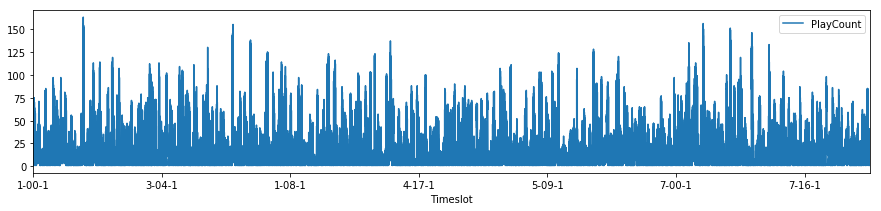

In [9]:
trainDf.plot(x='Timeslot', y='PlayCount',figsize=[15,3])

<h3 style="background-color:#616161;color:white">3. Construct prior probability from train data</h3>

Here we shall determine the alpa and beta parameters for a Beta distribution by calculating the probability of play in each timeslot, and then taking the mean and variance of this.

In [10]:
try:
    del trainDf['TotalWks']    # Delete col if it already exists
except KeyError:
    pass

# Calculate probability
trainDf=trainDf.set_index('UserID').join(wks)                      # Bring in total weeks from wks table
trainDf['Prob'] = trainDf['PlayCount'] / trainDf['TotalWks']      # Prob = num of plays in this period / total num of weeks
trainDf.reset_index(inplace=True)

# Calculate the Priors from trainDf. Note: We are taking the mean of the user means here
priorDf= trainDf.groupby('Timeslot')['Prob'].mean().to_frame('mean')  # Calculate the mean of prob for each period
priorDf['var'] = trainDf.groupby('Timeslot')['Prob'].var()           # Calculate the variance of prob for each period
a,b=estBetaParams(priorDf['mean'],priorDf['var'])                # Derive alpha & beta for the Beta dist
priorDf['a']= a                                                 # Store a and b back into priorDf
priorDf['b']= b

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Preview Results</div>

In [11]:
trainDf.head()

,UserID,Timeslot,PlayCount,TotalWks,Prob
0,1,1-00-1,4,107,0.037383
1,1,1-02-1,8,107,0.074766
2,1,1-05-1,2,107,0.018692
3,1,1-06-1,1,107,0.009346
4,1,1-07-1,1,107,0.009346


In [12]:
priorDf.head()

,mean,var,a,b
Timeslot,,,,
1-00-1,0.159880,0.018068,1.028700,5.405508
1-01-1,0.150697,0.019006,0.864106,4.869968
1-02-1,0.144178,0.019563,0.765181,4.542013
1-03-1,0.145752,0.020109,0.756675,4.434853
1-04-1,0.141437,0.019501,0.739269,4.487570


<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Additional Checks</div>

Let's do a few checks to make sure we've calculated the probability correctly.

Check that the min/max is within 0-1 boundaries

In [13]:
trainDf['Prob'].describe()

count    130237.000000
mean          0.181988
std           0.154171
min           0.004425
25%           0.063492
50%           0.140496
75%           0.258427
max           1.000000
Name: Prob, dtype: float64

Let's do a histogram to see what the distribution looks like

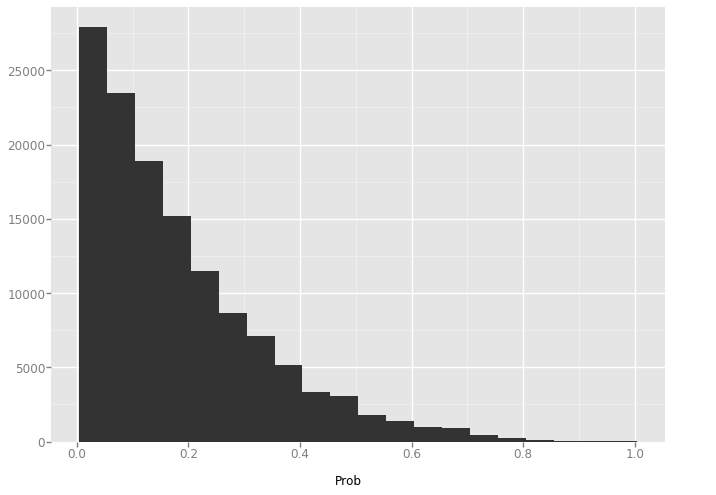

<ggplot: (-9223371928971080248)>

In [14]:
ggplot(aes(x='Prob'), data=trainDf) + \
    geom_histogram(binwidth=0.05)

The histogram above shows that most of the probabilities are very low which is as expected.

More crucially we can plot this distribution for a specific time-period.

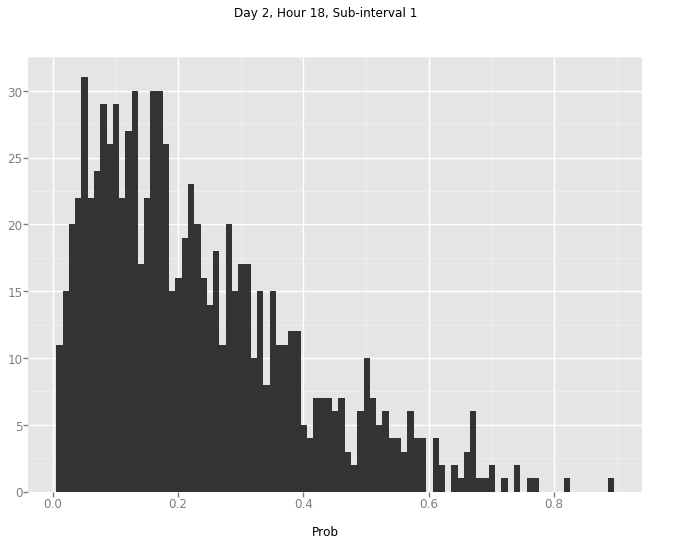

<ggplot: (107777129024)>

In [15]:
Timeslot='2-18-1'
ggplot(aes(x='Prob'), data=trainDf[trainDf.Timeslot==Timeslot]) + \
    geom_histogram(binwidth=0.01) + ggtitle("Day {}, Hour {}, Sub-interval {}".format(Timeslot[0],Timeslot[2:4],Timeslot[5]))

Hour 18 (6pm) is one of the most popular times for listening to music. We see that for some users this probability is as high as 0.9. It is the mean and variance for each of these timeslot distributions that will be used to form a set of alpha and betas for our prior beta distribution model, as shown below.

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Plot of Beta distribution for specific timeslot</div>

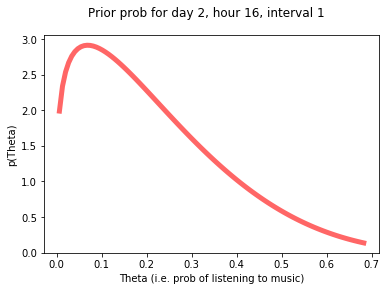

In [16]:
from scipy.stats import beta


p = '2-16-1'
a = priorDf.loc[p]['a']
b = priorDf.loc[p]['b']

# Plot our prior Beta PDF
fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)  # Generate prob distribution
ax.set_xlabel('Theta (i.e. prob of listening to music)')
ax.set_ylabel('p(Theta)')

fig.suptitle('Prior prob for day {}, hour {}, interval {}'.format(p[0],p[2:4],p[5]))
ax.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6)

<h3 style="background-color:#616161;color:white">4. Evaluation on test data - Part I (Plots)</h3>

We now have a set of priors for every Timeslot.
The next step is to take our untouched Test users and iterate through each of their plays in temporal order and see how our prior probability adapts as new observations come in.

In [17]:
# Fetch the test data
con = sqlite3.connect(dbPath)

SQLStr="""
SELECT M.UserID, PlayDate, Timeslot, count(*) as PlayCount from tblMainAgg as M 
INNER JOIN tblUsers ON M.UserID = tblUsers.UserID 
WHERE tblUsers.TestUser =1 GROUP BY M.UserID, PlayDate, Timeslot""".format(PeriodGranularity)
testDf = pd.read_sql_query(SQLStr, con)

con.close()
testDf["PlayDate"] = pd.to_datetime(testDf["PlayDate"])
testDf.sort_values(['UserID','PlayDate'], inplace=True)
print ('User IDs of test users',testDf['UserID'].unique())

User IDs of test users [ 59  93 132 142 525 543 571 639 813 820 887]


In [18]:
# Calculate each users prob
testDf.reset_index(inplace=True, drop=True)  # Important that this line is run every time the rest of it is run
for i in range (0,testDf.shape[0]):
    df =testDf.iloc[0:i]
    timeslot = testDf.iloc[i]['Timeslot']
    userID = testDf.iloc[i]['UserID']
    df=testDf.iloc[0:i]                                      # Extract just rows up to point i
    res = getNextPlayProb_Beta(df[df.UserID == userID],timeslot)   # Filter for the specific user and pass to function
    testDf.loc[(i),'EstProb'] = res

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Preview results</div>

In [24]:
testDf[(testDf.Timeslot == '1-17-1')].head()

,UserID,PlayDate,Timeslot,PlayCount,EstProb
1048,59,2008-03-30,1-17-1,1,0.025347
1061,59,2008-04-13,1-17-1,1,0.043420
1133,93,2008-03-23,1-17-1,1,0.168324
1207,93,2008-05-18,1-17-1,1,0.232526
1246,93,2008-05-25,1-17-1,1,0.300251


<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Plot some of the results</div>

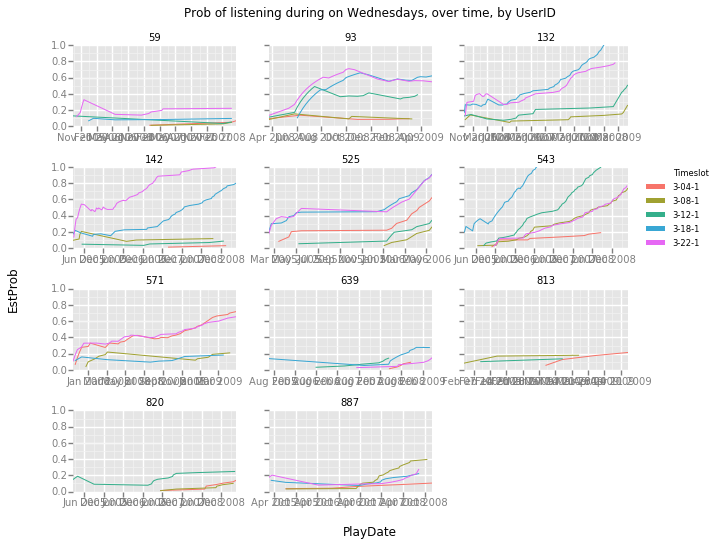

<ggplot: (-9223371927969432176)>

In [25]:
# Select timeslots to plot
t=['3-04-1','3-08-1','3-12-1','3-18-1','3-22-1']

df=testDf[(testDf.Timeslot.isin(t))]
ggplot(df, aes(x='PlayDate', y='EstProb',color='Timeslot')) + geom_line()  + scale_y_continuous(limits=(0,1)) + facet_wrap("UserID",scales="free_x") + ggtitle("Prob of listening during on Wednesdays, over time, by UserID") 


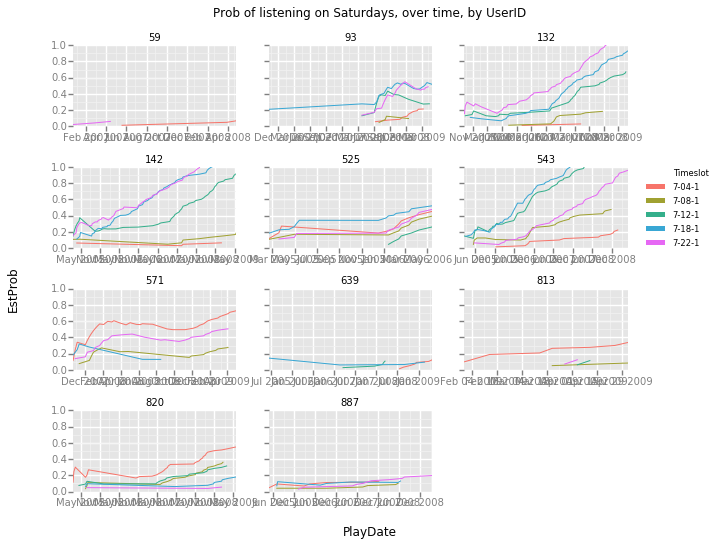

<ggplot: (108888782547)>

In [26]:
# Select timeslots to plot
t=['7-04-1','7-08-1','7-12-1','7-18-1','7-22-1']

df=testDf[(testDf.Timeslot.isin(t))]
ggplot(df, aes(x='PlayDate', y='EstProb',color='Timeslot')) + geom_line() + scale_y_continuous(limits=(0,1)) + facet_wrap("UserID",scales="free_x") + ggtitle("Prob of listening on Saturdays, over time, by UserID") 


In [27]:
# Check 2
#testDf[(testDf.UserID == 93)]
# Check 2
#testDf[(testDf.UserID == 93) & (testDf.Timeslot == '2-22-1')]
# Check 3
#testDf[testDf.UserID == u].groupby(['Timeslot'])['PlayCount'].sum()
# Additional checks
#testDf[testDf.UserID == u].groupby(['Timeslot'])['PlayCount'].sum().plot(figsize=[15,3])

<h3 style="background-color:#616161;color:white">5. Evaluation on test data - Part II</h3>

We now know that the Beta model adapts to persons preference over a couple of months, provided they are regular listeners. But we don't know how well this translates into a model for deciding whether to recommend listening to music. For this we shall use a probability threshold to determine whether to recommend music and assess the accuracy of the model over the test users history.

Let's start with a recap of the data we have.

In [11]:
testDf.head()

,UserID,PlayDate,Timeslot,PlayCount,EstProb
0,59,2005-09-09,6-16-1,1,0.214390
1,59,2005-09-09,6-17-1,1,0.189018
2,59,2005-09-09,6-18-1,1,0.190182
3,59,2005-09-09,6-19-1,1,0.185065
4,59,2005-09-12,2-13-1,1,0.158238


To measure the accuracy we will need to includes periods when the user <b>did not</b> listen to music. Hence we shall add additional rows into this table for cases where the user did not listen to music. The code below generates a sample set of periods to test on.

In [19]:
con = sqlite3.connect(dbPath)

# Fetch the test users
sqlStr = """Select UserID as UserID, FirstPlay, LastPlay, 
(strftime('%w',FirstPlay)+1) || '-' || (strftime('%H',FirstPlay)) || "-" || 
(cast(strftime('%M',FirstPlay) / {} +1 as int)) as Timeslot
from tblUsers where TestUser = 1""".format(PeriodGranularity)

users = pd.read_sql_query(sqlStr, con)
con.close()

# Get all play dates
testDf.PlayDate
# For each user select all the weeks that the test user listened to music at least once

for user in users.UserID:
    playDates = testDf[testDf.UserID == user].PlayDate.unique()
    playDates=playDates-pd.to_timedelta(p.dt.dayofweek, unit='D')
    playDates= testDf.PlayDate.drop_duplicates()
    
    # Generate all time slots in these periods
    for p in playDates:
        startOfWeek = p
        #do while currentDate <= p+:
        #    playDate = pd.to_datetime(firstPlay) + timedelta(hours=x)  

ValueError: operands could not be broadcast together with shapes (1545,) (307,) 

In [18]:
#testDf.PlayDate.drop_duplicates().dt.dayofweek
p= testDf.PlayDate.drop_duplicates()
p=p-pd.to_timedelta(p.dt.dayofweek, unit='D')

In [ ]:
con = sqlite3.connect(dbPath)

# Fetch the test users
sqlStr = """Select userID, FirstPlay, LastPlay, 
(strftime('%w',FirstPlay)+1) || '-' || (strftime('%H',FirstPlay)) || "-" || 
(cast(strftime('%M',FirstPlay) / {} +1 as int)) as Timeslot
from tblUsers where TestUser = 1""".format(PeriodGranularity)

users = pd.read_sql_query(sqlStr, con)
con.close()

# Convert to datetime
users['FirstPlay'] = pd.to_datetime(users['FirstPlay'])
users['LastPlay'] = pd.to_datetime(users['LastPlay'])

df=testDf.head(0)

d={}
d['UserID']={}
d['PlayDate']={}
d['Timeslot']={}
start = time.time()
i=0
maxRowsPerUser = 2000

for row in users.itertuples():
    userID=row.userID
    firstPlay=row.FirstPlay                    # Fetch the first play timestamp
    lastPlay=row.LastPlay
    hoursDiff = int((lastPlay-firstPlay).total_seconds()/60/60)
    j=0  
    for x in range (0, hoursDiff):           # Go through every hour that needs to be calculated
        playDate = pd.to_datetime(firstPlay) + timedelta(hours=x)          # Add on hours to firstPlay
        timeslot = toTimeSlot(playDate,PeriodGranularity)                  # Calculate timeslot  
        
        if j<= maxRowsPerUser:
            playDate= playDate.strftime('%Y-%m-%d')
            d['UserID'][i] = userID
            d['PlayDate'][i] = playDate
            d['Timeslot'][i] = timeslot
            i+=1
            j+=1
    
# Convert to dataframe
df=df.from_dict(d)
df["PlayDate"] = pd.to_datetime(df["PlayDate"])    # Convert it to datefield first!
df=df.merge(testDf,how='left',on=['Timeslot','PlayDate','UserID'])
df.fillna(0,inplace=True)
testDf = df
df=[]

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Preview results</div>

In [ ]:
testDf.head()

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Calculate all probs (this may take a while)</div>

In [ ]:
start = time.time()
testDf=CalcProb(testDf)
end = time.time()
print('Time ' + str((end - start)))

In [ ]:
# Calculate for user 1
testDf.head()

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Evaluate Score</div>

Here we look to see how well different thresholds for determining whether a probability should mean a user wishes to listen to music perform across each test user. The second number in each row is particularly important given that only a handful of all of the timeslots would represent 'listened to music'.

In [ ]:
def evaluateThreshold(df, thresholds):
    for t in thresholds:
        correct=0
        correctPos = df[(df.EstProb >= t) & (df.PlayCount>0)]['PlayCount'].count()
        correctNeg = correct + df[(df.EstProb < t) & (df.PlayCount==0)]['PlayCount'].count()
        totalRows = len(df)
        print("Threshold: {}. Total correct(+): {} Total correct(-): {} Total Rows:{}  %: {}".format(t,correctPos,correctNeg,totalRows,(correctPos+correctNeg)/totalRows))

for user in testDf.UserID.unique():
    print('User: {}'.format(user))
    evaluateThreshold(testDf,[0.03,0.05,0.1,0.2,0.3,0.5,0.6,0.7])



In [ ]:
from sklearn import metrics
import pandas as pd
from ggplot import *

actuals=testDf['PlayCount']
preds=(testDf['EstProb'])
fpr, tpr, _ = metrics.roc_curve(actuals, preds)

rocRes = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(rocRes, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

In [703]:
#testDf.PlayDate.drop_duplicates().dt.dayofweek
p= testDf.PlayDate.drop_duplicates()
#p=pd.to_datetime(p)
p+p #pd.to_timedelta(p.dt.dayofweek, unit='D')
 


TypeError: data type "datetime" not understood